In [1]:
print('hello')

hello


In [2]:
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pathlib import Path
import random
import os
import cv2

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [4]:

def get_file_list(root, file_type):
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

In [5]:
def get_train_df(ann_path, img_path):
    ann_path_list = get_file_list(ann_path, '.xml')
    ann_list = []
    for a_path in ann_path_list:
        root = ET.parse(a_path).getroot()
        ann = {}
        ann['filename'] = Path(str(img_path) + '/'+ root.find("./filename").text)
        ann['width'] = root.find("./size/width").text
        ann['height'] = root.find("./size/height").text
        ann['class'] = root.find("./object/name").text
        ann['xmin'] = int(root.find("./object/bndbox/xmin").text)
        ann['ymin'] = int(root.find("./object/bndbox/ymin").text)
        ann['xmax'] = int(root.find("./object/bndbox/xmax").text)
        ann['ymax'] = int(root.find("./object/bndbox/ymax").text)
        ann_list.append(ann)
    return pd.DataFrame(ann_list)

In [6]:
import kagglehub
import os
import pandas as pd
import xml.etree.ElementTree as ET
from pathlib import Path

# Download the dataset
path = kagglehub.dataset_download("andrewmvd/road-sign-detection")
print("Path to dataset files:", path)

# Now use this path as your base_path
base_path = path + '/'  # Add trailing slash
ann_path = base_path + 'annotations/'
img_path = base_path + 'images/'

print("Annotations path:", ann_path)
print("Images path:", img_path)
print("Annotations exist:", os.path.exists(ann_path))
print("Images exist:", os.path.exists(img_path))

# Your original function should now work
df_train = get_train_df(ann_path, img_path)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/admin/.cache/kagglehub/datasets/andrewmvd/road-sign-detection/versions/1
Annotations path: /Users/admin/.cache/kagglehub/datasets/andrewmvd/road-sign-detection/versions/1/annotations/
Images path: /Users/admin/.cache/kagglehub/datasets/andrewmvd/road-sign-detection/versions/1/images/
Annotations exist: True
Images exist: True


In [7]:
class_dict = {'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}
idx_to_class = {k:v for k,v in enumerate(list(class_dict.keys()))}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])
df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,/Users/admin/.cache/kagglehub/datasets/andrewm...,300,400,0,98,140,139,182
1,/Users/admin/.cache/kagglehub/datasets/andrewm...,300,400,0,136,92,177,135
2,/Users/admin/.cache/kagglehub/datasets/andrewm...,300,400,1,61,140,146,227
3,/Users/admin/.cache/kagglehub/datasets/andrewm...,300,400,0,115,169,149,205
4,/Users/admin/.cache/kagglehub/datasets/andrewm...,300,400,0,89,201,133,245


In [8]:
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

def create_bb_array(row_values):
    return np.array(row_values[4:8], dtype=int)  # Use Python's built-in int

In [9]:
def create_mask(bb, x):
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(int)  # Change this line from np.int to int
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

In [10]:

def resize_image_bb(read_path, write_path, bb, sz):
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [11]:
!rm -rf images_resized
!mkdir images_resized

In [12]:
new_paths = []
new_bbs = []
train_path_resized = Path('images_resized')

for index, row in df_train.iterrows():
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values),300)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
    
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

KeyboardInterrupt: 

In [ ]:
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

def random_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

def random_cropXY(x, Y, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

In [ ]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

In [ ]:
def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

In [ ]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

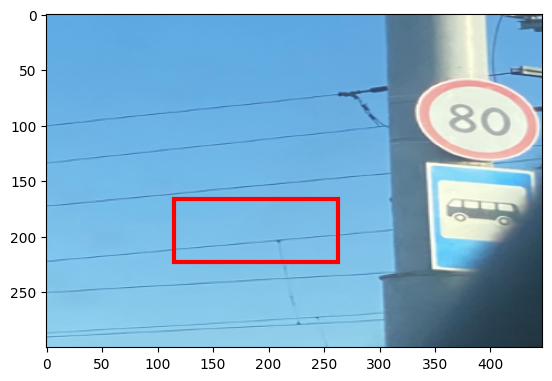

In [ ]:
im = cv2.imread(str(df_train.values[100][8]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train.values[100][9])

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import xml.etree.ElementTree as ET
import os
from PIL import Image


In [ ]:
import os

BASE_PATH = "/Users/admin/.cache/kagglehub/datasets/andrewmvd/road-sign-detection/versions/1"

IMAGES_PATH = os.path.join(BASE_PATH, "images")
ANNOTATIONS_PATH = os.path.join(BASE_PATH, "annotations")

print("Images:", len(os.listdir(IMAGES_PATH)))
print("Annotations:", len(os.listdir(ANNOTATIONS_PATH)))


Images: 877
Annotations: 877


In [ ]:
import kagglehub
path = kagglehub.dataset_download("andrewmvd/road-sign-detection")
print("Path to dataset files:", path)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/admin/.cache/kagglehub/datasets/andrewmvd/road-sign-detection/versions/1


In [ ]:
import xml.etree.ElementTree as ET

sample_xml = os.listdir(ANNOTATIONS_PATH)[0]
tree = ET.parse(os.path.join(ANNOTATIONS_PATH, sample_xml))
root = tree.getroot()

for obj in root.findall("object"):
    print(obj.find("name").text)


speedlimit
speedlimit


In [ ]:
LABELS = {
    "background": 0,
    "stop": 1,
    "trafficlight": 2,
    "speedlimit": 3,
    "crosswalk": 4
}

NUM_CLASSES = len(LABELS)


In [ ]:
unique_labels = set()

for xml_file in os.listdir(ANNOTATIONS_PATH):
    tree = ET.parse(os.path.join(ANNOTATIONS_PATH, xml_file))
    root = tree.getroot()

    for obj in root.findall("object"):
        unique_labels.add(obj.find("name").text.lower())

print(unique_labels)


{'speedlimit', 'trafficlight', 'stop', 'crosswalk'}


In [14]:
class RoadSignDataset(Dataset):
    def __init__(self, images_path, annotations_path, transforms=None):
        self.images_path = images_path
        self.annotations_path = annotations_path
        self.transforms = transforms
        self.image_files = sorted(os.listdir(images_path))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_file = self.image_files[idx]
        img_path = os.path.join(self.images_path, img_file)

        image = Image.open(img_path).convert("RGB")

        # 🔥 Correct XML filename conversion
        xml_file = os.path.splitext(img_file)[0] + ".xml"
        xml_path = os.path.join(self.annotations_path, xml_file)

        boxes = []
        labels = []

        tree = ET.parse(xml_path)
        root = tree.getroot()

        for obj in root.findall("object"):
            label_name = obj.find("name").text.lower()
            label_id = LABELS.get(label_name, 0)

            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label_id)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels
        }

        if self.transforms:
            image = self.transforms(image)

        return image, target


In [18]:
BASE_PATH = "/Users/admin/.cache/kagglehub/datasets/andrewmvd/road-sign-detection/versions/1"

IMAGES_PATH = os.path.join(BASE_PATH, "images")
ANNOTATIONS_PATH = os.path.join(BASE_PATH, "annotations")

print("Images:", len(os.listdir(IMAGES_PATH)))
print("Annotations:", len(os.listdir(ANNOTATIONS_PATH)))


Images: 877
Annotations: 877


In [17]:
import os
import torch
import xml.etree.ElementTree as ET
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as T


In [19]:
LABELS = {
    "background": 0,
    "stop": 1,
    "trafficlight": 2,
    "speedlimit": 3,
    "crosswalk": 4
}


In [20]:
class RoadSignDataset(Dataset):
    def __init__(self, images_path, annotations_path, transforms=None):
        self.images_path = images_path
        self.annotations_path = annotations_path
        self.transforms = transforms
        self.image_files = sorted(os.listdir(images_path))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_file = self.image_files[idx]
        img_path = os.path.join(self.images_path, img_file)

        image = Image.open(img_path).convert("RGB")

        xml_file = os.path.splitext(img_file)[0] + ".xml"
        xml_path = os.path.join(self.annotations_path, xml_file)

        boxes = []
        labels = []

        tree = ET.parse(xml_path)
        root = tree.getroot()

        for obj in root.findall("object"):
            label_name = obj.find("name").text.lower()
            label_id = LABELS.get(label_name, 0)

            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label_id)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}

        if self.transforms:
            image = self.transforms(image)

        return image, target


In [21]:
transform = T.Compose([
    T.ToTensor()
])

dataset = RoadSignDataset(IMAGES_PATH, ANNOTATIONS_PATH, transforms=transform)

print("Dataset size:", len(dataset))


Dataset size: 877


In [22]:
image, target = dataset[0]

print("Image shape:", image.shape)
print("Boxes:", target["boxes"])
print("Labels:", target["labels"])


Image shape: torch.Size([3, 400, 267])
Boxes: tensor([[ 98.,  62., 208., 232.]])
Labels: tensor([2])


In [23]:
image, target = dataset[0]

print("Image shape:", image.shape)
print("Boxes:", target["boxes"])
print("Labels:", target["labels"])


Image shape: torch.Size([3, 400, 267])
Boxes: tensor([[ 98.,  62., 208., 232.]])
Labels: tensor([2])


In [ ]:
class RoadSignDataset(Dataset):
    def __init__(self, images_path, annotations_path, transforms=None):
        self.images_path = images_path
        self.annotations_path = annotations_path
        self.transforms = transforms
        self.image_files = sorted(os.listdir(images_path))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_file = self.image_files[idx]
        img_path = os.path.join(self.images_path, img_file)

        image = Image.open(img_path).convert("RGB")

        xml_file = os.path.splitext(img_file)[0] + ".xml"
        xml_path = os.path.join(self.annotations_path, xml_file)

        boxes = []
        labels = []

        tree = ET.parse(xml_path)
        root = tree.getroot()

        for obj in root.findall("object"):
            label_name = obj.find("name").text.lower()
            label_id = LABELS.get(label_name, 0)

            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label_id)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels
        }

        if self.transforms:
            image = self.transforms(image)

        return image, target


In [26]:
class RoadSignDataset(Dataset):
    def __init__(self, images_path, annotations_path, transforms=None):
        self.images_path = images_path
        self.annotations_path = annotations_path
        self.transforms = transforms
        self.image_files = sorted(os.listdir(images_path))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_file = self.image_files[idx]
        img_path = os.path.join(self.images_path, img_file)

        image = Image.open(img_path).convert("RGB")

        xml_file = os.path.splitext(img_file)[0] + ".xml"
        xml_path = os.path.join(self.annotations_path, xml_file)

        boxes = []
        labels = []

        tree = ET.parse(xml_path)
        root = tree.getroot()

        for obj in root.findall("object"):
            label_name = obj.find("name").text.lower()
            label_id = LABELS.get(label_name, 0)

            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label_id)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels
        }

        if self.transforms:
            image = self.transforms(image)

        return image, target


In [28]:
import os
import torch
import torchvision
import xml.etree.ElementTree as ET
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as T
from sklearn.model_selection import train_test_split


In [29]:
transform = T.Compose([
    T.ToTensor()
])

dataset = RoadSignDataset(IMAGES_PATH, ANNOTATIONS_PATH, transforms=transform)

indices = list(range(len(dataset)))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)

train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))


Train size: 701
Val size: 176


In [31]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn

model = fasterrcnn_resnet50_fpn(
    weights=None,
    weights_backbone=None
)


In [32]:
in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
    in_features,
    len(LABELS)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)


In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        train_loss += losses.item()

    print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}")


In [ ]:
model.eval()
val_loss = 0

with torch.no_grad():
    for images, targets in val_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        val_loss += losses.item()

print("Validation Loss:", val_loss/len(val_loader))


In [ ]:
torch.save(model.state_dict(), "cv_model.pth")
